# Classification Cluster Part 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import fix_yahoo_finance as yf
yf.pdr_override()

In [2]:
stocks_dict = {
    'Advanced Micro Devices':'AMD',
    'Amazon': 'AMZN',
    'Apple': 'AAPL',
    'Walgreen': 'WBA',
    'Northrop Grumman': 'NOC',
    'Boeing': 'BA',
    'Lockheed Martin': 'LMT',
    'McDonalds':  'MCD',
    'Intel': 'INTC',
    'Navistar': 'NAV',
    'IBM': 'IBM',
    'Texas Instruments': 'TXN',
    'MasterCard': 'MA',
    'Microsoft': 'MSFT',
    'General Electrics': 'GE',
    'Symantec': 'SYMC',
    'American Express': 'AXP',
    'Pepsi': 'PEP',
    'Coca Cola': 'KO',
    'Johnson & Johnson': 'JNJ',
    'Toyota': 'TM',
    'Honda': 'HMC',
    'Mistubishi': 'MSBHY',
    'Sony': 'SNE',
    'Exxon': 'XOM',
    'Chevron': 'CVX',
    'Valero Energy': 'VLO',
    'Ford': 'F',
    'Bank of America': 'BAC', 
    'Petrobras': 'PBR',
    'Vale': 'VALE'}

In [3]:
# Split dict into list of companies and symbols
names, symbols = np.array(list(stocks_dict.items())).T

In [5]:
start = '2017-01-01'
end = '2017-12-31'

print("Downloading values for period %s to %s:" % (start, end))
dataset = [yf.download(symbol,start,end) for symbol in symbols]
print("Done!")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [29]:
market_dates = np.vstack([dataset.index])
open_price = np.array([p["Open"] for p in dataset]).astype(np.float)
high_price = np.array([p["High"] for p in dataset]).astype(np.float)
low_price = np.array([p["Low"] for p in dataset]).astype(np.float)
close_price = np.array([p["Adj Close"] for p in dataset]).astype(np.float)
volume_price = np.array([p["Volume"] for p in dataset]).astype(np.float)

In [8]:
# Calculate percent change
X = (close_price - open_price) / open_price

In [32]:
# The daily variations of the quotes are what carry most information
variation = close_price - open_price

In [33]:
from sklearn import cluster, covariance, manifold

# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [34]:
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Microsoft, McDonalds, MasterCard, Symantec, Texas Instruments
Cluster 2: Lockheed Martin, Northrop Grumman, Boeing
Cluster 3: Honda, Ford, Exxon, Intel, Chevron, Pepsi, Coca Cola, Toyota, Walgreen, IBM, Mistubishi, General Electrics, Valero Energy, Johnson & Johnson
Cluster 4: Navistar
Cluster 5: Advanced Micro Devices
Cluster 6: Bank of America, American Express
Cluster 7: Petrobras, Vale
Cluster 8: Sony, Amazon, Apple


In [35]:
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

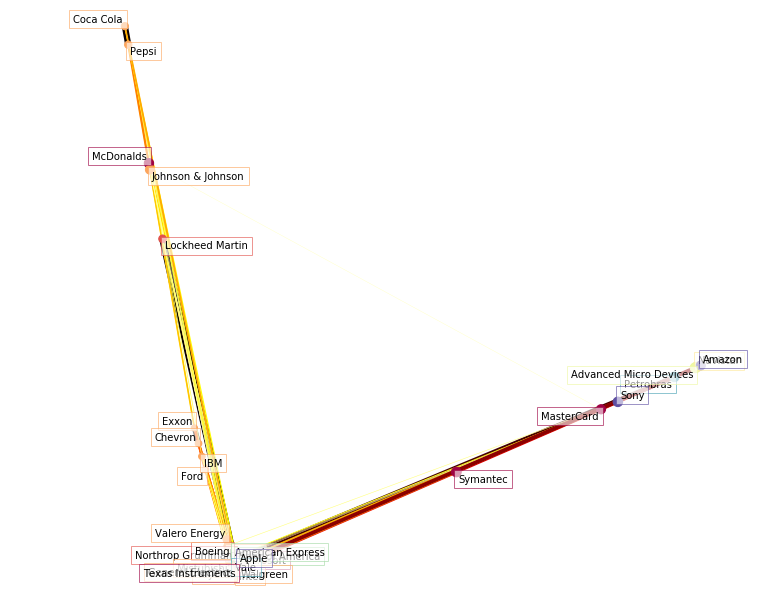

In [48]:
# #############################################################################
import matplotlib.cm as cm
cmap = cm.get_cmap("Spectral")

# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=cmap)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=cmap(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()